In [0]:
# importamos los archivos del repositorio del paper de Wouter Kool(2018-9):
!git clone https://github.com/wouterkool/attention-learn-to-route.git

Cloning into 'attention-learn-to-route'...
remote: Enumerating objects: 243, done.
remote: Total 243 (delta 0), reused 0 (delta 0), pack-reused 243
Receiving objects: 100% (243/243), 74.66 MiB | 38.51 MiB/s, done.
Resolving deltas: 100% (53/53), done.


In [0]:
import os

In [0]:
!ls

attention-learn-to-route  LICENSE	  problems		  train.py
environment.yml		  nets		  __pycache__		  utils
eval.py			  options.py	  README.md
generate_data.py	  plot_vrp.ipynb  reinforce_baselines.py
images			  pretrained	  run.py


In [0]:
os.chdir('attention-learn-to-route') # cambiar directorio

In [0]:
os.listdir()

['options.py',
 'utils',
 'README.md',
 'train.py',
 '.git',
 'images',
 'pretrained',
 'problems',
 'plot_vrp.ipynb',
 'generate_data.py',
 'LICENSE',
 'reinforce_baselines.py',
 'eval.py',
 'run.py',
 'nets',
 'environment.yml',
 '.gitignore']

# Modelo corrido desde el notebook provisto por el autor del paper

Adaptado de: `plot_vrp.ipynb`

In [0]:
import numpy as np
import torch 
from torch.utils.data import DataLoader
from generate_data import generate_vrp_data
from utils import load_model
from problems import CVRP

import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

%matplotlib inline

In [0]:
# Code inspired by Google OR Tools plot:
# https://github.com/google/or-tools/blob/fb12c5ded7423d524fc6c95656a9bdc290a81d4d/examples/python/cvrptw_plot.py

def discrete_cmap(N, base_cmap=None):
  """
  Create an N-bin discrete colormap from the specified input map
  """
  # Note that if base_cmap is a string or None, you can simply do
  #    return plt.cm.get_cmap(base_cmap, N)
  # The following works for string, None, or a colormap instance:

  base = plt.cm.get_cmap(base_cmap)
  color_list = base(np.linspace(0, 1, N))
  cmap_name = base.name + str(N)
  return base.from_list(cmap_name, color_list, N)

def plot_vehicle_routes(data, route, ax1, markersize=5, visualize_demands=False, demand_scale=1, round_demand=False):
    """
    Plot the vehicle routes on matplotlib axis ax1.
    """
    
    # route is one sequence, separating different routes with 0 (depot)
    routes = [r[r!=0] for r in np.split(route.cpu().numpy(), np.where(route==0)[0]) if (r != 0).any()]
    depot = data['depot'].cpu().numpy()
    locs = data['loc'].cpu().numpy()
    demands = data['demand'].cpu().numpy() * demand_scale
    capacity = demand_scale # Capacity is always 1
    
    x_dep, y_dep = depot
    ax1.plot(x_dep, y_dep, 'sk', markersize=markersize*4)
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)
    
    legend = ax1.legend(loc='upper center')
    
    cmap = discrete_cmap(len(routes) + 2, 'nipy_spectral')
    dem_rects = []
    used_rects = []
    cap_rects = []
    qvs = []
    total_dist = 0
    for veh_number, r in enumerate(routes):
        color = cmap(len(routes) - veh_number) # Invert to have in rainbow order
        
        route_demands = demands[r - 1]
        coords = locs[r - 1, :]
        xs, ys = coords.transpose()

        total_route_demand = sum(route_demands)
        assert total_route_demand <= capacity
        if not visualize_demands:
            ax1.plot(xs, ys, 'o', mfc=color, markersize=markersize, markeredgewidth=0.0)
        
        dist = 0
        x_prev, y_prev = x_dep, y_dep
        cum_demand = 0
        for (x, y), d in zip(coords, route_demands):
            dist += np.sqrt((x - x_prev) ** 2 + (y - y_prev) ** 2)
            
            cap_rects.append(Rectangle((x, y), 0.01, 0.1))
            used_rects.append(Rectangle((x, y), 0.01, 0.1 * total_route_demand / capacity))
            dem_rects.append(Rectangle((x, y + 0.1 * cum_demand / capacity), 0.01, 0.1 * d / capacity))
            
            x_prev, y_prev = x, y
            cum_demand += d
            
        dist += np.sqrt((x_dep - x_prev) ** 2 + (y_dep - y_prev) ** 2)
        total_dist += dist
        qv = ax1.quiver(
            xs[:-1],
            ys[:-1],
            xs[1:] - xs[:-1],
            ys[1:] - ys[:-1],
            scale_units='xy',
            angles='xy',
            scale=1,
            color=color,
            label='R{}, # {}, c {} / {}, d {:.2f}'.format(
                veh_number, 
                len(r), 
                int(total_route_demand) if round_demand else total_route_demand, 
                int(capacity) if round_demand else capacity,
                dist
            )
        )
        
        qvs.append(qv)
        
    ax1.set_title('{} routes, total distance {:.2f}'.format(len(routes), total_dist))
    ax1.legend(handles=qvs)
    
    pc_cap = PatchCollection(cap_rects, facecolor='whitesmoke', alpha=1.0, edgecolor='lightgray')
    pc_used = PatchCollection(used_rects, facecolor='lightgray', alpha=1.0, edgecolor='lightgray')
    pc_dem = PatchCollection(dem_rects, facecolor='black', alpha=1.0, edgecolor='black')
    
    if visualize_demands:
        ax1.add_collection(pc_cap)
        ax1.add_collection(pc_used)
        ax1.add_collection(pc_dem)

In [0]:
# Función creada para personalizar la carga de modelos guardados
# y la futura inferencia sobre datos reales:

def carga_modelo_y_gen_data(ruta_modelo_grabado='pretrained/cvrp_100/',
                            cant_nodos=100, cant_instancias=10):
  model, _ = load_model(ruta_modelo_grabado)
  torch.manual_seed(1234)
  dataset = CVRP.make_dataset(size=cant_nodos, num_samples=cant_instancias)
  # Need a dataloader to batch instances
  dataloader = DataLoader(dataset, batch_size=cant_nodos)
  return model, dataset, dataloader

In [0]:
model, dataset, dataloader = carga_modelo_y_gen_data(ruta_modelo_grabado='pretrained/cvrp_100/',
                                                     cant_nodos=100, cant_instancias=10)

  [*] Loading model from pretrained/cvrp_100/epoch-99.pt


In [0]:
# Resumen del modelo de inferencia:
model

AttentionModel(
  (init_embed_depot): Linear(in_features=2, out_features=128, bias=True)
  (init_embed): Linear(in_features=3, out_features=128, bias=True)
  (embedder): GraphAttentionEncoder(
    (layers): Sequential(
      (0): MultiHeadAttentionLayer(
        (0): SkipConnection(
          (module): MultiHeadAttention()
        )
        (1): Normalization(
          (normalizer): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (2): SkipConnection(
          (module): Sequential(
            (0): Linear(in_features=128, out_features=512, bias=True)
            (1): ReLU()
            (2): Linear(in_features=512, out_features=128, bias=True)
          )
        )
        (3): Normalization(
          (normalizer): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): MultiHeadAttentionLayer(
        (0): SkipConnection(
          (module): MultiHeadAttention()
        )
        

In [0]:
# Función personalizada para realizar una construcción de ruta:
def construir_una_ruta(model, dataset, batch, decode_type='greedy'):
  # Run the model
  model.eval() # activar modo de evaluación, no de entrenamiento
  model.set_decode_type(decode_type)
  with torch.no_grad(): # evita que la historia de cómputo se grabe por 'autograd'
    length, log_p, pi = model(batch, return_pi=True)
  tours = pi
  
  # Plot the results
  for i, (data, tour) in enumerate(zip(dataset, tours)):
      fig, ax = plt.subplots(figsize=(10, 10))
      plot_vehicle_routes(data, tour, ax, visualize_demands=False, demand_scale=1000, round_demand=True)
      # fig.savefig(os.path.join('images', 'cvrp_{}.png'.format(i)))
  return tours # secuencia decodificada

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


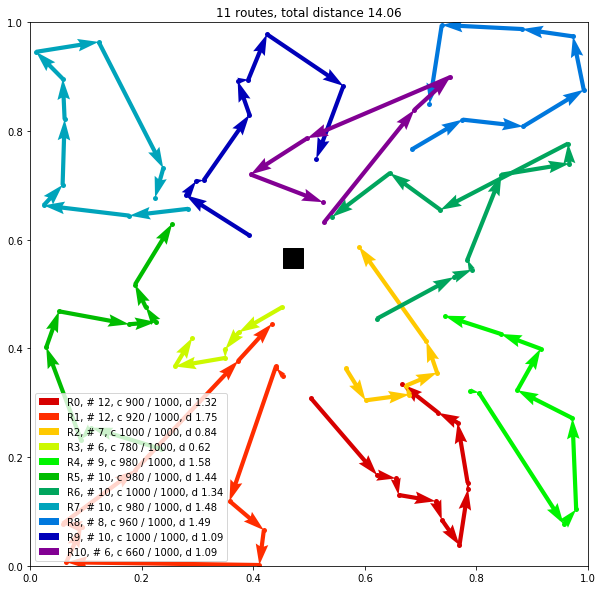

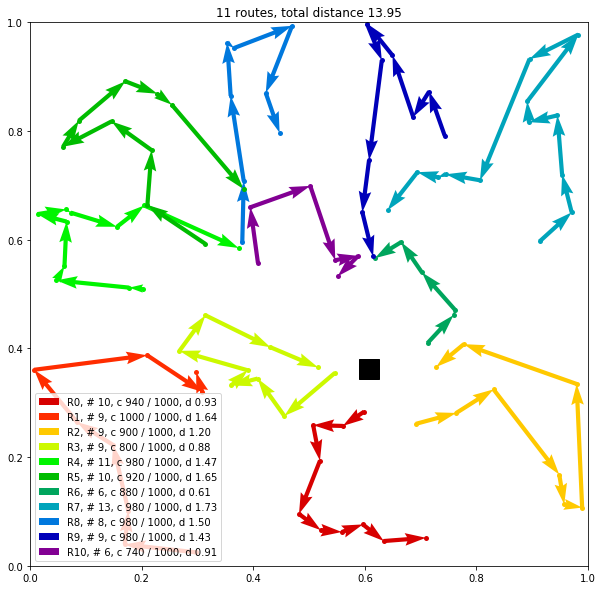

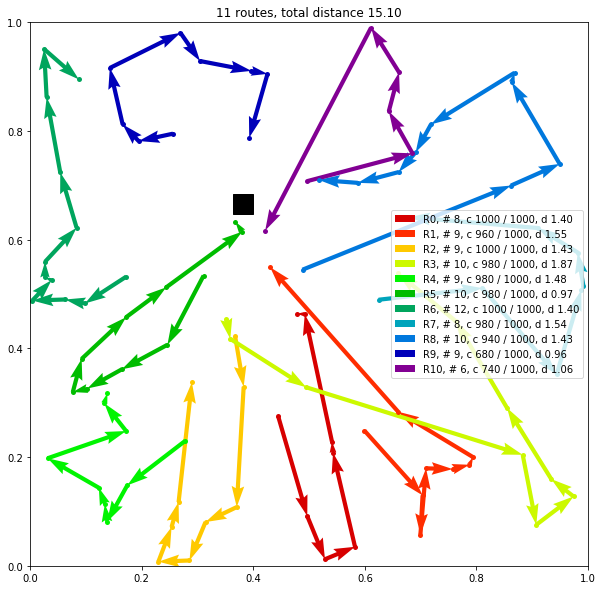

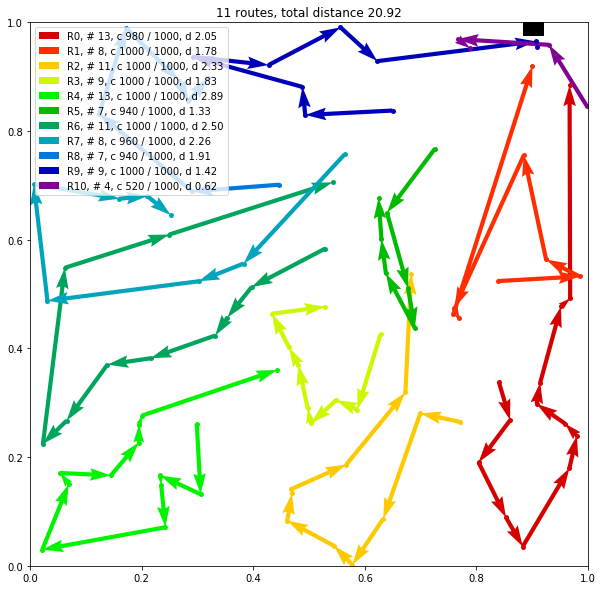

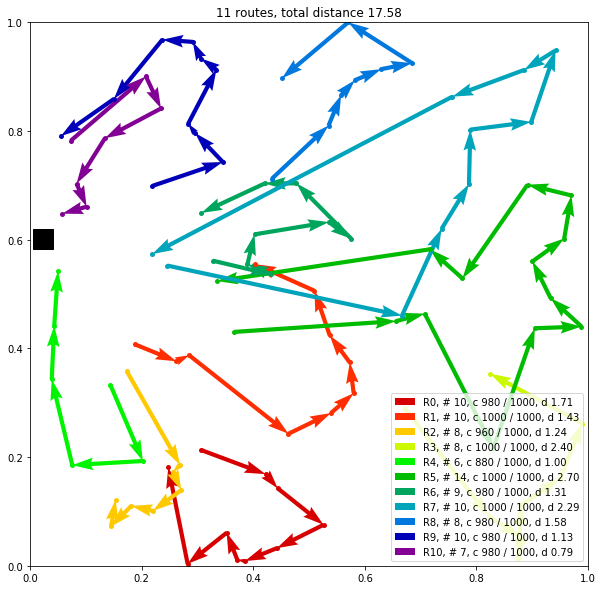

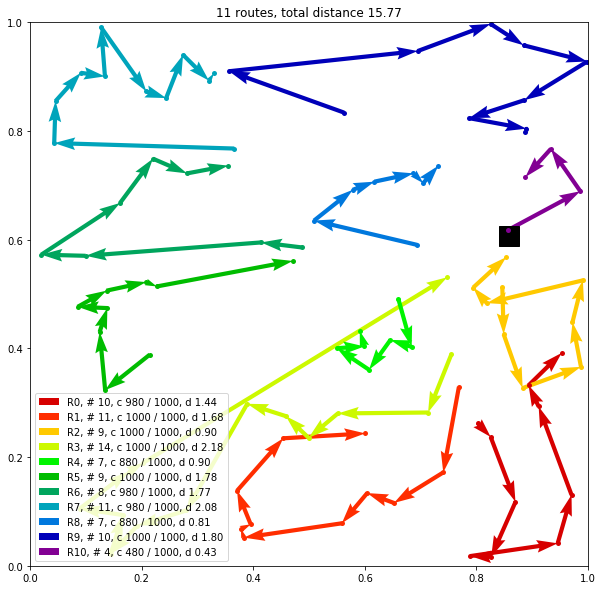

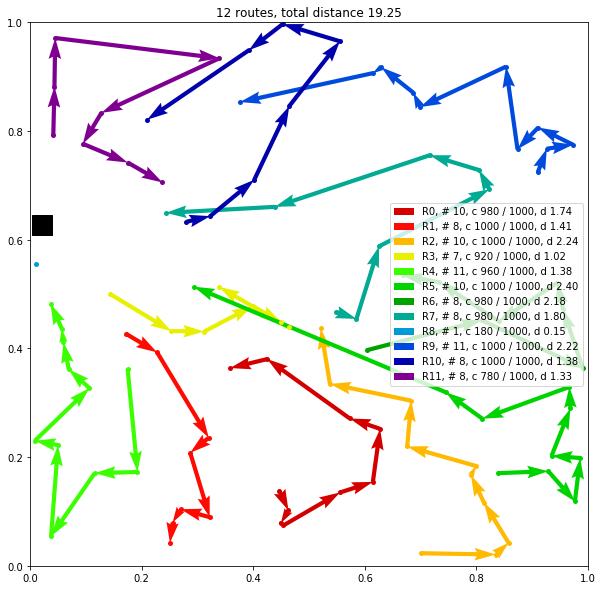

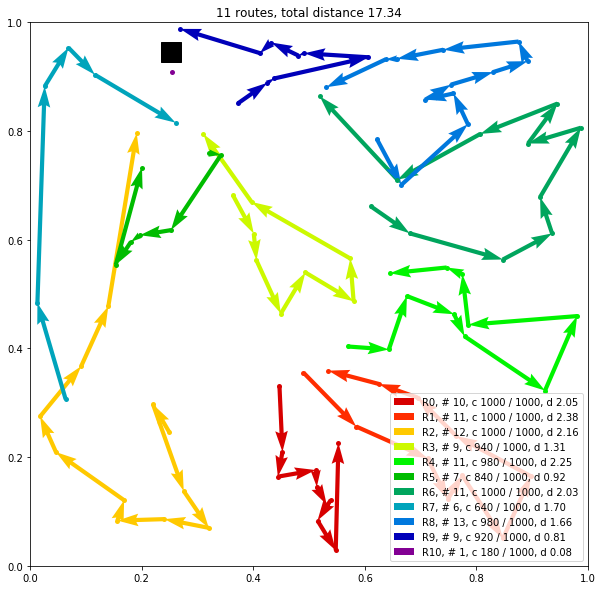

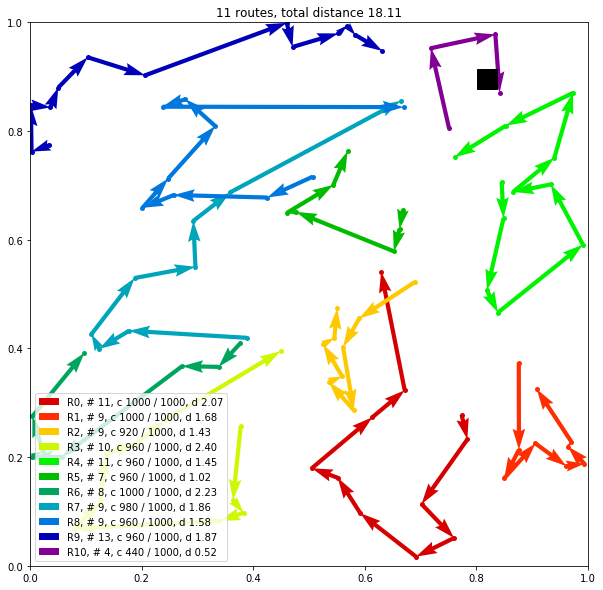

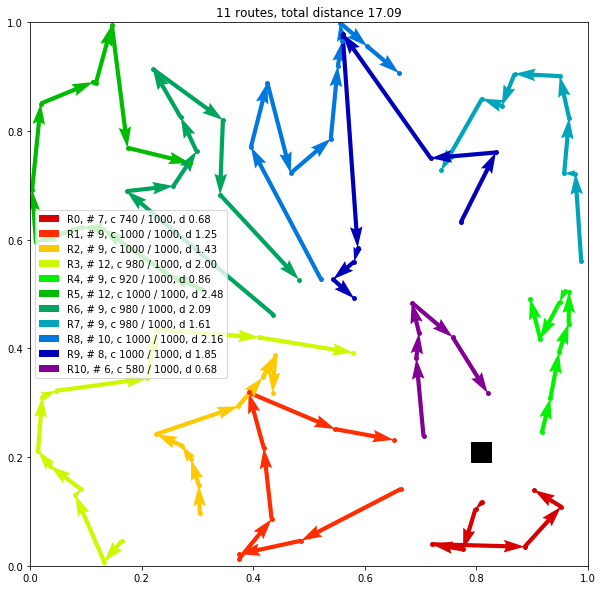

In [0]:
# Realizar predicciones!!!
historia_instancia_tour = {}
i = 1
for batch in dataloader:
  tour_decodificado = construir_una_ruta(model=model, dataset=dataset, batch=batch, decode_type='greedy')
  historia_instancia_tour[i] = tour_decodificado
  i+=1

In [0]:
historia_instancia_tour.keys()

dict_keys([1])

In [0]:
a_dict = {}

In [0]:
arbitrary_array = historia_instancia_tour[1][0].numpy()

In [0]:
import pandas as pd

In [0]:
pd.DataFrame(pd.Series(arbitrary_array).value_counts()).T

,0,36,26,27,28,29,30,31,32,33,...,64,65,66,67,68,69,70,71,72,50
0,10,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [0]:
historia_instancia_tour[1][0]

tensor([ 56,  67,  96,  32,  48,  73,  44,  40,  15,  38,  54,  16,   0,  59,
         52,  97,  86,  24,  21,  55,  64,  83,  84,  36,  30,   0,  94,  11,
         75,   5,  69,  82,  79,   0,  14,  57,  72,  33,   2,  35,   0,  17,
         34,  20,  62,  95,  65,  28,  19,  60,   0,  89,  29,  47,   1,   4,
         42,  93,  90,  39,  12,   0,  99,  50,  66,   6,  81,  13,  80,  85,
         51,  22,   0,   9,  78,  61,   3,  71,  91,  37,  43,  10,  45,   0,
         27,   7,  25,  87,  58,  53,  88,  98,   0,  63,   8,  23,  41,  68,
        100,  76,  74,  70,  92,   0,  46,  77,  26,  31,  49,  18])

In [0]:
random_array = np.random.randint(0, 10, (3,5))
random_array.shape

(3, 5)

In [0]:
random_array

array([[9, 6, 5, 2, 8],
       [8, 1, 6, 5, 0],
       [6, 6, 7, 0, 7]])

In [0]:
random_array[0:2,:]

array([[9, 6, 5, 2, 8],
       [8, 1, 6, 5, 0]])

In [0]:
historia_instancia_tour[1].shape

torch.Size([3, 110])